In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [4]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(link, sep=';')

In [9]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

In [102]:
clf = DecisionTreeClassifier()
print('accuracy: ', cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean())

accuracy:  0.44090056285178236


In [103]:
clf = BaggingClassifier(n_estimators=100)
print('accuracy: ', cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean())

accuracy:  0.5647279549718573


In [104]:
clf = RandomForestClassifier(n_estimators=100)
print('accuracy: ', cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean())

accuracy:  0.5703564727954972


2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [116]:
estimators = [10, 50, 100, 200] + [x for x in range(400, 5001, 200)]

results = dict()
for estimator_num in estimators:
    clf = RandomForestClassifier(n_estimators=estimator_num).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[str(estimator_num)] = accuracy_score(y_test, y_pred)

In [117]:
pd.DataFrame.from_dict(results, orient='index', columns=['accuracy'])

,accuracy
10,0.622917
50,0.662500
100,0.668750
200,0.666667
400,0.670833
600,0.664583
800,0.677083
1000,0.677083
1200,0.675000
1400,0.664583


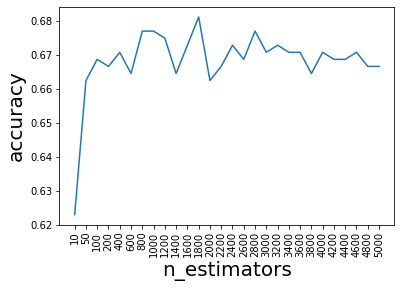

In [142]:
plt.plot(results.keys(),results.values())
plt.xticks(rotation=90)
plt.xlabel('n_estimators', size=20)
plt.ylabel('accuracy', size=20)
plt.show()

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [173]:
clf = GradientBoostingClassifier().fit(X_train, y_train)
print('accuracy',  cross_val_score(clf, X_test, y_test, cv=3, scoring = 'accuracy').mean())

accuracy 0.5437500000000001


In [7]:
clf = XGBClassifier().fit(X_train, y_train)
print('accuracy',  cross_val_score(clf, X_test, y_test, cv=3,scoring = 'accuracy').mean())

accuracy 0.5458333333333334


5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [11]:
parametrs = {'max_depth' : range(1,10), 'n_estimators': range (1, 10), 'learning_rate': np.linspace(0.01,2,10)}
clf = GradientBoostingClassifier()
search = GridSearchCV(clf, parametrs, scoring='accuracy', n_jobs=-1, cv=3)
fit_clf = search.fit(X_train, y_train)
print("Accuracy:", fit_clf.score(X_test, y_test))
search.best_params_

Accuracy: 0.6354166666666666


{'learning_rate': 0.45222222222222225, 'max_depth': 7, 'n_estimators': 9}

In [12]:
parametrs = {'max_depth' : range(1,10), 'n_estimators': range (1, 10), 'learning_rate': np.linspace(0.01,2,10)}
clf = XGBClassifier()
search = GridSearchCV(clf, parametrs, scoring='accuracy', n_jobs=-1, cv=3)
fit_clf = search.fit(X_train, y_train)
print("Accuracy:", fit_clf.score(X_test, y_test))
search.best_params_

Accuracy: 0.6291666666666667


{'learning_rate': 0.45222222222222225, 'max_depth': 8, 'n_estimators': 9}

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

#### LightGBM оперативно не установился ((

In [15]:
clf = CatBoostClassifier(silent=True).fit(X_train, y_train)
print('accuracy',  cross_val_score(clf, X_test, y_test, cv=3, scoring = 'accuracy').mean())

accuracy 0.5645833333333333


7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [17]:
clf = CatBoostClassifier(silent=True)
search = GridSearchCV(clf, parametrs, scoring='accuracy', n_jobs=-1, cv=3)
fit_clf = search.fit(X_train, y_train)
print("Accuracy:", fit_clf.score(X_test, y_test))
search.best_params_

Accuracy: 0.575


{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 9}

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [23]:
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'n_estimators':     hp.choice('n_estimators',    np.arange(5, 30))
}

xgb_fit_params = {
    'eval_metric': 'mlogloss',
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: 1 - accuracy_score(y, pred)

class HPOpt(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test
        self.result = 0

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            self.result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return self.result, trials

    def xgb_reg(self, para):
        reg =XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        eval_set = [(self.X_train, self.y_train), (self.X_test, self.y_test)]
        reg.fit(self.X_train, self.y_train, eval_set=eval_set, **para['fit_params'])
        pred = reg.predict(self.X_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}
    
    def return_result(self):
        return self.result

In [24]:
obj = HPOpt(X_train, X_test, y_train, y_test)
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=1000)

100%|████████████| 1000/1000 [06:35<00:00,  2.53trial/s, best loss: 0.33333333333333337]


In [26]:
print(obj.return_result())

{'learning_rate': 5, 'max_depth': 1, 'n_estimators': 23}


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [27]:
estimators = [
    ('GBC', GradientBoostingClassifier()),
    ('XGB', XGBClassifier()),
    ('CatBoost', CatBoostClassifier())
]
stacking = StackingClassifier(estimators=estimators, cv=3, n_jobs=-1)
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [28]:
estimators_tuned = [
    ('GBC', GradientBoostingClassifier(
        learning_rate=0.45222222222222225,
        max_depth=7,
        n_estimators=9)
    ),
    ('XGB', XGBClassifier(
        learning_rate=0.45222222222222225,
        max_depth=8,
        n_estimators=9)
    ),
    ('CatBoost', CatBoostClassifier(
        learning_rate=0.01,
        max_depth=9,
        n_estimators=9)
    )
]
stacking_tuned = StackingClassifier(estimators=estimators_tuned, cv=3, n_jobs=-1)
stacking_tuned.fit(X_train, y_train)
y_pred_tuned = stacking_tuned.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))

Accuracy: 0.6520833333333333


Стэкинг без оптимальных параметров сработал лучше.